# Magnetic moment reversal of $m_z$-component

Loading programm modules:
- **LinearAlgebra** $-$ mathematical functions;
- **Plots** $-$ drawing graphs;
- **DifferentialEquations** $-$ solving ODEs;
- **StaticArrays** $-$ static arrays;
- **Distributed** $-$ multithreading;
- **BenchmarkTools** $-$ counting working time.

In [1]:
using LinearAlgebra
using Plots
using DifferentialEquations
using StaticArrays
using Distributed
using BenchmarkTools

Checking the number of threads

In [2]:
Threads.nthreads()

1

Set of input parameters:
- **G** $-$ relation of Josephson energy to energy of magnetic anisotropy;
- **r** $-$ the spin-orbit coupling parameter;
- **alpha** $-$ damping parametr;
- **As** $-$ the amplitude of the pulse current;
- **t_s** $-$ time point the maximal amplitude;
- **delta_t** $-$ current pulse duration;
- **t0** $-$ start of integration time;
- **tf** $-$ end of integration time;
- **nt** $-$ number of points for creation current pulse curve.

In [3]:
G =18
r=0.1
alpha=0.1
As=1.5
t_s=25
delta_t=6
t0=0
tf=100
nt=1000

1000

Create current pulse function and current pulse curve

In [4]:
function I_pulse(t,As,t_s,delta_t)
    I_puls=0
    if (t_s-1/2*delta_t) <= t && t <= (t_s + 1/2*delta_t)
        I_puls=As
    end
    
    return I_puls
end
#arrays for current pulse curve data
y_I=zeros(nt)
t_e=zeros(nt)
# step calculating
step=(tf-t0)/nt
# create range
t_e=range(t0,tf,length=nt)
for i in 1:nt
    y_I[i]=I_pulse(t_e[i],As,t_s,delta_t)
   end

Create right side function with parameters:
- **du** $-$ the desired vector function;
- **u** $-$ input vector of initial values;
- **p** $-$ input vector of static parameters;
- **t** $-$ time range.

In [5]:
function mysfs!(du,u,p,t)
    mx,my,mz,ph=u
    G,r,alpha,As, t_s,delta_t=p

    w=1.0
    Hx=0
    Hy=G*r*sin(ph-r*my)
    Hz=mz

    H=[Hx,Hy,Hz]
    M=[mx,my,mz]

    m2=dot(M,M)
    HdM=dot(H,M)

    alpha2= -1/(1+alpha*alpha*m2)
    Iv=I_pulse(t,As,t_s,delta_t)
    du[1] =dmx= alpha2 *((my*Hz-mz*Hy)+ alpha * (mx*HdM-Hx))
    du[2] =dmy= alpha2 *((mz*Hx-mx*Hz)+ alpha * (my*HdM-Hy))
    du[3] =dmz= alpha2 *((mx*Hy-my*Hx)+ alpha * (mz*HdM-Hz))
    du[4] =dph= (r * dmy) - (1/w * sin(ph-r*my)) + (Iv/w)
    
end

mysfs! (generic function with 1 method)

Creation set of parameters for mass calculation

In [6]:
u0=[0,0,1,0]
tspan = (t0, tf)

datasizeG=100
datasizeAlpha=100
datacount=datasizeG*datasizeAlpha
G0=1
delta_G=1
alpha0=0.1
delta_alpha=0.01
#creation parameters vector
parameters = [[G0+delta_G*i,r,alpha0+delta_alpha*j,As, t_s,delta_t] for i in 1:datasizeG for j in 1:datasizeAlpha]

10000-element Vector{Vector{Float64}}:
 [2.0, 0.1, 0.11, 1.5, 25.0, 6.0]
 [2.0, 0.1, 0.12000000000000001, 1.5, 25.0, 6.0]
 [2.0, 0.1, 0.13, 1.5, 25.0, 6.0]
 [2.0, 0.1, 0.14, 1.5, 25.0, 6.0]
 [2.0, 0.1, 0.15000000000000002, 1.5, 25.0, 6.0]
 [2.0, 0.1, 0.16, 1.5, 25.0, 6.0]
 [2.0, 0.1, 0.17, 1.5, 25.0, 6.0]
 [2.0, 0.1, 0.18, 1.5, 25.0, 6.0]
 [2.0, 0.1, 0.19, 1.5, 25.0, 6.0]
 [2.0, 0.1, 0.2, 1.5, 25.0, 6.0]
 [2.0, 0.1, 0.21000000000000002, 1.5, 25.0, 6.0]
 [2.0, 0.1, 0.22, 1.5, 25.0, 6.0]
 [2.0, 0.1, 0.23, 1.5, 25.0, 6.0]
 ⋮
 [101.0, 0.1, 0.99, 1.5, 25.0, 6.0]
 [101.0, 0.1, 1.0, 1.5, 25.0, 6.0]
 [101.0, 0.1, 1.01, 1.5, 25.0, 6.0]
 [101.0, 0.1, 1.02, 1.5, 25.0, 6.0]
 [101.0, 0.1, 1.03, 1.5, 25.0, 6.0]
 [101.0, 0.1, 1.04, 1.5, 25.0, 6.0]
 [101.0, 0.1, 1.05, 1.5, 25.0, 6.0]
 [101.0, 0.1, 1.06, 1.5, 25.0, 6.0]
 [101.0, 0.1, 1.07, 1.5, 25.0, 6.0]
 [101.0, 0.1, 1.08, 1.5, 25.0, 6.0]
 [101.0, 0.1, 1.09, 1.5, 25.0, 6.0]
 [101.0, 0.1, 1.1, 1.5, 25.0, 6.0]

Create mass calculation function for repeating calculation with different set of parameters

In [7]:
function prob_func(problem, i, repeat)
    remake(problem, p = parameters[i])
end

prob_func (generic function with 1 method)

Modify output for saving only lst point of mz-component

In [8]:
function output_func(solution, i)
    (SVector{1, Float64}( solution[end][3]), false)
end

output_func (generic function with 1 method)

Create ODEProblem object for first element of set of parameters

In [9]:
prob1 = ODEProblem(mysfs!, u0, tspan, parameters[1])

ODEProblem with uType Vector{Int64} and tType Int64. In-place: true
Non-trivial mass matrix: false
timespan: (0, 100)
u0: 4-element Vector{Int64}:
 0
 0
 1
 0

Create EnsebleProblem object for mass solving

In [10]:
ensemble_prob = EnsembleProblem(prob1, prob_func = prob_func, output_func = output_func, safetycopy = false)

EnsembleProblem with problem ODEProblem

Solving EnsembleProblem object in multithreaading mode
- **ensemble_prob** $-$ EnsembleProblem object;
- **EnsembleThreads()** $-$ using multithreading;
- **trajectories** $-$ count of sets of parameters;
- **dtmax** $-$ maximum step for the variable step method;
- **reltol** $-$ relative tolerance;
- **abstol** $-$ absolute tolerance.

In [11]:
sol2=solve(ensemble_prob,EnsembleThreads(),trajectories = datacount,dtmax=0.1,reltol=1e-8,abstol=1e-8)

EnsembleSolution Solution of length 10000 with uType:
SVector{1, Float64}

Selecting points that satisfy the flip condition and plotting them on the graph

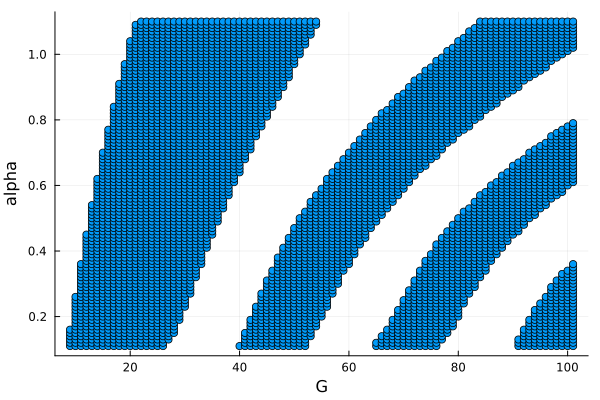

In [12]:
points=Any[]
point=Float64[2]

outfile = "pts.dat"
open(outfile, "w") do f1
    for i in 1:datacount
        if abs(sol2[i][1]+1.0)<0.0005
            local point=[parameters[i][1] parameters[i][3]]
            x1= parameters[i][1]
            x2= parameters[i][3]
            x3= sol2[i][1]
            push!(points,point)
            println(f1, "$x1    $x2     $x3")
        end
    end
end
points

plot(first.(points),last.(points),seriestype=:scatter,ylabel="alpha",xlabel="G",label=false)